In [1]:
from pathlib import Path

import gym
import navstack_gym
import torch

import numpy as np
import matplotlib.pyplot as plt
import h5py

from gym.wrappers import TimeLimit, FrameStack
from algo.wrapper import ResizeObservation, TensorObservation

from pprint import pprint as p

from algo import utils
from algo import agent

print(torch.cuda.is_available())

True


In [2]:
experiment_name = 'subtask_fixed_room'
env_id = 'VisibleKeyHunt-v0'

In [3]:
# agent param
feature_dim = 50
hidden_dim = 1024
lr = 1e-4
image_pad = 4
gamma = 0.99
replay_start_size = 2000
gpu = 0
batch_size = 256
update_interval = 2
capacity = 10 ** 5

# learning param
n_episodes = 2000
eval_step = 10

# task param
set_seed = True
env_seed = 1234
change_room = False
change_pose = True
stack_num = 2
max_episode_steps = 50

In [4]:
utils.create_workspace(experiment_name)
workspace_path = utils.get_workspace_path(experiment_name)

set workspace: work/maintask_fixed_room


In [5]:
room_param = utils.load_param('conf', 'room_generation.yaml')
env_param = utils.load_param('conf', 'env_mode.yaml')

In [6]:
p(env_param.full.items())

[('map_size', 150),
 ('map_resolution', 0.1),
 ('spawn_extension', 0.5),
 ('path_exploration_count', 2500),
 ('path_planning_count', 7),
 ('avoidance_size', 3),
 ('move_limit', 20),
 ('movable_discount', 6),
 ('found_threshold', 0.6),
 ('map_obs_val', 100),
 ('map_pass_val', 0),
 ('map_unk_val', 50)]


In [7]:
env = gym.make(env_id, **env_param.full)
env = ResizeObservation(env, 84)
env = FrameStack(env, stack_num)
env = TensorObservation(env)
env = TimeLimit(env, max_episode_steps=max_episode_steps)

/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [8]:
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space
obs_size = obs_space.low.size
action_size = action_space.low.size
prior_observation_count = stack_num

print(f'timelimit: \t{timestep_limit}')
print(f'obs_space: \t{obs_space.shape} \naction_space: \t{action_space.shape}')
print(f'obs_size: \t{obs_size}')
print(f'action_size: \t{action_size}')
print(f'obs_stack: \t{prior_observation_count}')

timelimit: 	50
obs_space: 	(2, 84, 84) 
action_space: 	(3,)
obs_size: 	14112
action_size: 	3
obs_stack: 	2


/home/tagokeniot/tmp/wrapper.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.as_tensor(observation, dtype=torch.float32)
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/tagokeniot/tmp/.venv/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning

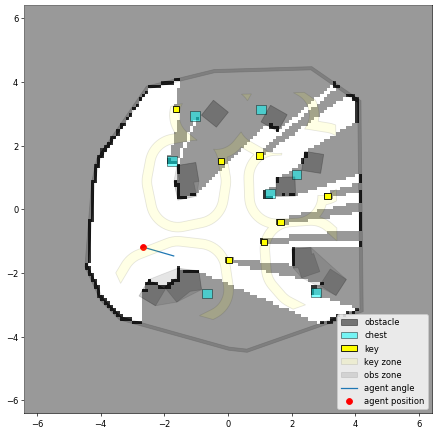

In [9]:
if set_seed:
    np.random.seed(env_seed)
    
obs = env.reset(**room_param.hodoyoi)
plt.imshow(env.render('rgb_array'))

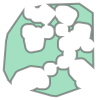

In [10]:
env.scener.sample_area

In [11]:
agent = agent.make_DrQ_agent(
    experiment_name=experiment_name, 
    obs_space=env.observation_space, 
    action_space=env.action_space,
    feature_dim=feature_dim,
    hidden_dim=hidden_dim,
    lr=lr,
    image_pad=image_pad,
    gamma=gamma,
    replay_start_size=replay_start_size,
    capacity=capacity,
    gpu=gpu,
    batch_size=batch_size,
    update_interval=update_interval,
    is_persistent_buffer=True)

set workspace: work/maintask_fixed_room


In [12]:
result_filename = f'{str(workspace_path)}/result.hdf5'

with h5py.File(result_filename, 'a') as f:
    agent_statics_group = 'agent_statics'
    agent_statics_labels = [s[0] for s in agent.get_statistics()]
    for l in agent_statics_labels:
        f.create_dataset(f'{agent_statics_group}/{l}', shape=(n_episodes,))

    episode_rewards_group = 'episode_rewards'
    episode_rewards_labels = ['episode', 'total_reward']
    for l in episode_rewards_labels:
        f.create_dataset(f'{episode_rewards_group}/{l}', shape=(n_episodes,))


In [13]:
import datetime
start = datetime.datetime.now()
print(f'\n====================\nStart Training: {start}\n====================\n')

for i in range(n_episodes):
    obs = env.reset(is_generate_room=change_room, is_generate_pose=change_pose, **room_param.hodoyoi)
    R = 0  # return (sum of rewards)
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        R += reward
        
        agent.observe(obs, reward, done, done)
        if done:
            break

    p('=============')
    p(f'episode: {i}, reward: {R}')
    p(f'statics: {agent.get_statistics()}')
    
    ## record result
    with h5py.File(result_filename, 'a') as f:
        f[episode_rewards_group]['episode'][i] = i+1
        f[episode_rewards_group]['total_reward'][i] = R
        for statics in agent.get_statistics():
            f[agent_statics_group][statics[0]][i] = statics[1]

print('Finished')
print(f'\n====================\nTraining Time: {datetime.datetime.now() - start}\n====================\n')

'============='
'episode: 0, reward: -2.000000000000001'
("statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', "
 "nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', "
 "nan), ('temperature', 1.0)]")
'============='
'episode: 1, reward: -2.000000000000001'
("statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', "
 "nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', "
 "nan), ('temperature', 1.0)]")
'============='
'episode: 2, reward: 48.000000000000014'
("statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', "
 "nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', "
 "nan), ('temperature', 1.0)]")
'============='
'episode: 3, reward: -2.000000000000001'
("statics: [('average_q1', nan), ('average_q2', nan), ('average_q_func1_loss', "
 "nan), ('average_q_func2_loss', nan), ('n_updates', 0), ('average_entropy', "
 "nan), ('temperature', 1.0)]")
'===

In [ ]:
agent.save(f'{str(workspace_path)}/agent')